In [ ]:
%reload_ext autoreload
%autoreload 2

import io
import os
from datetime import datetime

import numpy as np
import pandas as pd
import requests
from dotenv import load_dotenv
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sqlalchemy import create_engine

%matplotlib widget

load_dotenv()

DB_HOST = os.environ.get("DB_HOST", "150.145.51.193")
DB_PORT = os.environ.get("DB_PORT", "5432")
DB_NAME = os.environ.get("DB_NAME", "planpincieux")
DB_USER = os.environ.get("DB_USER", "")
DB_PASSWORD = os.environ.get("DB_PASSWORD", "")

APP_HOST = os.environ.get("APP_HOST", "150.145.51.193")
APP_PORT = os.environ.get("APP_PORT", "8001")
GET_IMAGE_VIEW = os.environ.get("GET_IMAGE_VIEW", "images")

target_date = "2024-08-23"
camera_name = "PPCX_Tele"
# dic_id = 3098

min_velocity = 1  # Minimum velocity threshold in pixels, use -1 to disable
filter_outliers = True  # Whether to filter out low velocity vectors
tails_percentile = 0.001  # Percentile for tail filtering

# Create the connection to the database
db_engine = create_engine(
    f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

In [131]:
def get_dic_analysis_ids(
    db_engine,
    *,
    reference_date: str | datetime | None = None,
    master_timestamp: str | datetime | None = None,
    camera_id: int | None = None,
    camera_name: str | None = None,
) -> pd.DataFrame:
    """
    Get DIC analysis metadata (including IDs) for a specific date/timestamp and optional camera filter.
    """
    query = """
    SELECT 
        DIC.id as dic_id,
        CAM.camera_name,
        DIC.master_timestamp,
        DIC.slave_timestamp,
        DIC.master_image_id,
        DIC.slave_image_id,
        DIC.time_difference_hours
    FROM ppcx_app_dic DIC
    JOIN ppcx_app_image IMG ON DIC.master_image_id = IMG.id
    JOIN ppcx_app_camera CAM ON IMG.camera_id = CAM.id
    WHERE 1=1
    """
    params = []
    if reference_date is not None:
        query += " AND DATE(DIC.reference_date) = %s"
        params.append(str(reference_date))
    if master_timestamp is not None:
        query += " AND DATE(DIC.master_timestamp) = %s"
        params.append(str(master_timestamp))
    if camera_id is not None:
        query += " AND CAM.id = %s"
        params.append(camera_id)
    if camera_name is not None:
        query += " AND CAM.camera_name = %s"
        params.append(camera_name)
    query += " ORDER BY DIC.master_timestamp"
    return pd.read_sql(query, db_engine, params=tuple(params))


def get_dic_data_api(
    dic_id: int,
    app_host: str = APP_HOST,
    app_port: str = APP_PORT,
    filter_outliers: bool = False,
    tails_percentile: float = 0.01,
    min_velocity: float = -1,
) -> pd.DataFrame:
    """
    Fetch DIC displacement data from the Django API endpoint as a DataFrame.
    """
    url = f"http://{app_host}:{app_port}/API/dic/{dic_id}/"
    response = requests.get(url)
    if response.status_code != 200:
        raise ValueError(f"Could not fetch DIC data for id {dic_id}: {response.text}")

    data = response.json()
    points = data["points"]
    vectors = data["vectors"]
    magnitudes = data["magnitudes"]

    # Convert to DataFrame
    df = pd.DataFrame(points, columns=["x", "y"])
    df["u"] = [v[0] for v in vectors]
    df["v"] = [v[1] for v in vectors]
    df["V"] = magnitudes

    # Filter out extreme tails based on the specified percentile
    if filter_outliers:
        prob_threshold = (tails_percentile, 1 - tails_percentile)
        velocity_percentiles = df["V"].quantile(prob_threshold).values
        df = df[
            (df["V"] >= velocity_percentiles[0]) & (df["V"] <= velocity_percentiles[1])
        ].reset_index(drop=True)

    # Filter out low velocity vectors if specified
    if min_velocity >= 0:
        df = df[df["V"] >= min_velocity].reset_index(drop=True)

    return df


def get_image(
    image_id: int,
    app_host: str = APP_HOST,
    app_port: str = APP_PORT,
    camera_name: str | None = None,
) -> Image.Image:
    """Get an image from the database by its ID and rotate if from Tele camera."""
    url = f"http://{app_host}:{app_port}/API/images/{image_id}/"
    response = requests.get(url)
    if response.status_code == 200:
        img = Image.open(io.BytesIO(response.content))
        # Rotate if camera_name is Tele (portrait mode)
        if camera_name is not None and "tele" in camera_name.lower():
            img = img.rotate(90, expand=True)  # 90° clockwise
        return img
    else:
        raise ValueError(f"Image with ID {image_id} not found.")

In [132]:
# Get DIC analysis metadata (filtered by date/camera)
dic_analyses = get_dic_analysis_ids(
    db_engine, reference_date=target_date, camera_name=camera_name
)
dic_analyses

,dic_id,camera_name,master_timestamp,slave_timestamp,master_image_id,slave_image_id,time_difference_hours
0,9,PPCX_Tele,2024-08-22 11:47:34+00:00,2024-08-23 11:03:33+00:00,26608,26625,23.3
1,8,PPCX_Tele,2024-08-22 11:49:06+00:00,2024-08-23 11:03:33+00:00,26609,26625,23.2
2,7,PPCX_Tele,2024-08-22 11:51:23+00:00,2024-08-23 11:03:33+00:00,26610,26625,23.2
3,6,PPCX_Tele,2024-08-22 11:51:38+00:00,2024-08-23 11:03:33+00:00,26611,26625,23.2
4,5,PPCX_Tele,2024-08-22 11:58:56+00:00,2024-08-23 11:03:33+00:00,26612,26625,23.1
5,4,PPCX_Tele,2024-08-22 12:12:24+00:00,2024-08-23 12:03:35+00:00,26614,26626,23.9
6,3,PPCX_Tele,2024-08-22 13:03:34+00:00,2024-08-23 13:03:33+00:00,26615,26627,24.0
7,2,PPCX_Tele,2024-08-22 14:03:35+00:00,2024-08-23 14:03:33+00:00,26616,26628,24.0


In [133]:
# Get the master image for the DIC analysis via the API
master_image_id = dic_analyses["master_image_id"].iloc[0]
img = get_image(master_image_id, camera_name=camera_name)

# Fetch the displacement data for that DIC analysis via the API
dic_id = dic_analyses["dic_id"].iloc[0]
df = get_dic_data_api(
    dic_id,
    filter_outliers=filter_outliers,
    tails_percentile=tails_percentile,
    min_velocity=min_velocity,
)

(<Figure size 800x500 with 2 Axes>,
 <Axes: >,
 <matplotlib.quiver.Quiver at 0x78b36e4c4a70>)

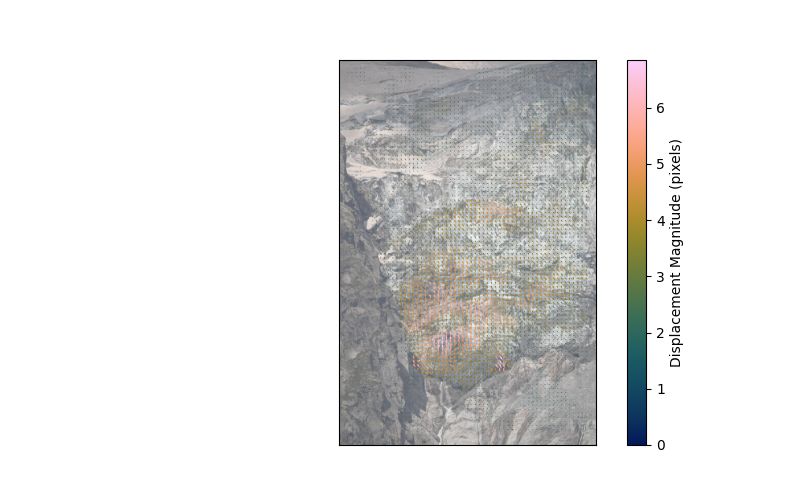

In [134]:
from src.visualization import plot_dic_vectors

fig, ax = plt.subplots(figsize=(8, 5))
plot_dic_vectors(
    x=df["x"].to_numpy(),
    y=df["y"].to_numpy(),
    u=df["u"].to_numpy(),
    v=df["v"].to_numpy(),
    magnitudes=df["V"].to_numpy(),
    background_image=img,
    cmap_name="batlow",
    # vmin=0.1,
    # vmax=10,
    fig=fig,
    ax=ax,
)

In [135]:
def preproc_features(df):
    """
    Create additional features for clustering glacier displacement data
    """
    df_features = df.copy()

    # Direction angle (in radians and degrees)
    df_features["angle_rad"] = np.arctan2(df["v"], df["u"])
    df_features["angle_deg"] = np.degrees(df_features["angle_rad"])

    # Convert negative angles to positive (0-360 degrees)
    df_features["angle_deg"] = (df_features["angle_deg"] + 360) % 360

    # Directional components (unit vectors)
    df_features["u_unit"] = df["u"] / (df["V"] + 1e-10)  # Avoid division by zero
    df_features["v_unit"] = df["v"] / (df["V"] + 1e-10)

    # Spatial derivatives (approximate gradients)
    # Note: This is a simplified approach - in practice you might want to use proper spatial interpolation
    df_features["spatial_index"] = range(len(df_features))

    # Log magnitude for better clustering of different scales
    df_features["log_magnitude"] = np.log1p(df["V"])

    # Magnitude categories
    magnitude_percentiles = np.percentile(df["V"], [25, 50, 75])
    df_features["magnitude_category"] = pd.cut(
        df["V"],
        bins=[0] + list(magnitude_percentiles) + [np.inf],
        labels=["low", "medium", "high", "very_high"],
    )

    return df_features


def normalize_data(
    df,
    spatial_weight=0.3,
    velocity_weight=0.7,
    spatial_features_names=None,
    velocity_features_names=None,
):
    """
    Custom clustering approach that considers both spatial proximity and velocity similarity

    Parameters:
    - spatial_weight: weight for spatial coordinates (x, y)
    - velocity_weight: weight for velocity features (u, v, magnitude, direction)
    """

    if spatial_features_names is None:
        spatial_features_names = ["x", "y"]
    if velocity_features_names is None:
        velocity_features_names = ["u", "v", "V", "angle_deg"]

    # Prepare features for clustering
    spatial_features = df[spatial_features_names].values
    velocity_features = df[velocity_features_names].values

    # Normalize features separately
    spatial_scaler = StandardScaler()
    velocity_scaler = StandardScaler()

    spatial_normalized = spatial_scaler.fit_transform(spatial_features)
    velocity_normalized = velocity_scaler.fit_transform(velocity_features)

    # Create a DataFrame with normalized features
    normalized_df = pd.DataFrame(
        np.hstack(
            [
                spatial_normalized * spatial_weight,
                velocity_normalized * velocity_weight,
            ]
        ),
        columns=spatial_features_names + velocity_features_names,
    )

    return normalized_df, spatial_scaler, velocity_scaler


def visualize_uv_plt(df, ax=None, **kwargs):
    """
    Visualize the u-v scatter plot with optional background image.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))

    V = df["V"].values if "V" in df else np.sqrt(df["u"] ** 2 + df["v"] ** 2)
    scatter = ax.scatter(
        df["u"], df["v"], s=1, c=V, alpha=0.6, cmap="viridis", **kwargs
    )
    ax.set_xlabel("u (displacement in x direction)")
    ax.set_ylabel("v (displacement in y direction)")
    ax.set_title("Displacement Vectors (u-v Scatter Plot)")
    plt.colorbar(scatter, ax=ax)
    ax.set_aspect("equal", adjustable="box")


def visualize_pca(df, columns_to_extract=None, normalize=False):
    "visualize the enhanced features using PCA for dimensionality reduction"
    from sklearn.decomposition import PCA

    # Prepare data for PCA
    if columns_to_extract is None:
        columns_to_extract = ["x", "y", "u", "v", "V", "angle_deg"]

    # Ensure all required columns are present in the DataFrame
    missing_columns = set(columns_to_extract) - set(df.columns)
    if missing_columns:
        raise ValueError(f"Missing columns in DataFrame: {missing_columns}")

    if normalize:
        scaler = StandardScaler()
        data = scaler.fit_transform(df[columns_to_extract])
    else:
        data = df[columns_to_extract].values

    # Reduce to 2D using PCA
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)
    df_reduced = pd.DataFrame(reduced_data, columns=["PC1", "PC2"])

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.scatter(df_reduced["PC1"], df_reduced["PC2"], s=1, alpha=0.6)
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_title("PCA Reduced Features Scatter Plot")
    ax.set_aspect("equal", adjustable="box")


def plot_clustering_results(df, labels, var_names=None, img=None, figsize=(15, 10)):
    """
    Visualize clustering results on the glacier displacement field.
    Simplified version inspired by plot_dic_vectors function.
    """
    fig, axes = plt.subplots(2, 2, figsize=figsize)

    # Get unique labels and create colors
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels[unique_labels >= 0])  # Exclude noise (-1)

    # Use a colormap for consistent colors
    if n_clusters > 0:
        cmap = plt.get_cmap("Set3")
        colors = cmap(np.linspace(0, 1, max(n_clusters, 3)))
        # Handle noise points with red color
        color_map = {}
        cluster_idx = 0
        for label in unique_labels:
            if label == -1:
                color_map[label] = "red"
            else:
                color_map[label] = colors[cluster_idx % len(colors)]
                cluster_idx += 1
    else:
        color_map = {-1: "red"}

    # Plot 1: Spatial distribution of clusters
    ax1 = axes[0, 0]
    for label in unique_labels:
        mask = labels == label
        if np.any(mask):
            cluster_name = "Noise" if label == -1 else f"Cluster {label}"
            ax1.scatter(
                df.loc[mask, "x"],
                df.loc[mask, "y"],
                c=[color_map[label]],
                s=2,
                alpha=0.7,
                label=cluster_name,
            )

    ax1.set_title("Spatial Distribution")
    ax1.invert_yaxis()  # Match image coordinates
    ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    ax1.set_aspect("equal")
    ax1.grid(False)
    ax1.set_xlabel("")
    ax1.set_ylabel("")
    ax1.set_xticks([])
    ax1.set_yticks([])

    # Plot 2: Displacement vectors colored by velocity magnitude (like plot_dic_vectors)
    ax2 = axes[0, 1]
    if img is not None:
        ax2.imshow(img, alpha=0.7)
    q = ax2.quiver(
        df["x"],
        df["y"],
        df["u"],
        df["v"],
        df["V"],  # Color by velocity magnitude
        scale=None,
        scale_units="xy",
        angles="xy",
        cmap="viridis",
        width=0.003,
        headwidth=2.5,
        alpha=0.8,
    )
    cbar = fig.colorbar(q, ax=ax2)
    cbar.set_label("Displacement Magnitude (pixels)")
    ax2.set_title("Displacement Vectors")
    ax2.grid(False)
    ax2.set_aspect("equal")
    ax2.set_xlabel("")
    ax2.set_ylabel("")
    ax2.set_xticks([])
    ax2.set_yticks([])

    # Plot 3: 2D scatter plot of two variables (e.g., angle vs magnitude)
    ax3 = axes[1, 0]
    if var_names is None:
        var_names = ["angle_deg", "V"]
    if len(var_names) != 2:
        raise ValueError(
            "var_names must contain exactly two variable names for the 2D scatter plot."
        )
    if not all(var in df.columns for var in var_names):
        raise ValueError(
            f"One or both of the specified variables {var_names} do not exist in the DataFrame."
        )
    for label in unique_labels:
        mask = labels == label
        if np.any(mask):
            cluster_name = "Noise" if label == -1 else f"Cluster {label}"
            ax3.scatter(
                df.loc[mask, var_names[0]],
                df.loc[mask, var_names[1]],
                c=[color_map[label]],
                s=15,
                alpha=0.6,
                label=cluster_name,
            )
    ax3.set_title("2D Scatter Plot")
    ax3.set_xlabel(var_names[0])
    ax3.set_ylabel(var_names[1])
    ax3.grid(True, alpha=0.3)
    ax3.legend()

    # Plot 4: Cluster statistics
    ax4 = axes[1, 1]
    cluster_stats = []
    for label in unique_labels:
        mask = labels == label
        cluster_name = "Noise" if label == -1 else f"Cluster {label}"

        stats = {
            "Cluster": cluster_name,
            "Count": np.sum(mask),
            "Mean_Magnitude": df.loc[mask, "V"].mean(),
            "Mean_Direction": df.loc[mask, "angle_deg"].mean(),
            "Std_Magnitude": df.loc[mask, "V"].std(),
        }
        cluster_stats.append(stats)
    stats_df = pd.DataFrame(cluster_stats)

    # Bar plot of cluster sizes
    bars = ax4.bar(
        range(len(stats_df)),
        stats_df["Count"],
        color=[color_map[label] for label in unique_labels],
    )

    ax4.set_title("Cluster Sizes")
    ax4.set_xlabel("Cluster")
    ax4.set_ylabel("Number of Points")
    ax4.set_xticks(range(len(stats_df)))
    ax4.set_xticklabels(stats_df["Cluster"], rotation=45)
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return stats_df

In [136]:
df_features = preproc_features(df)

In [ ]:
# --- Run GMM clustering and plot ---
variables_names = ["x", "y", "V", "angle_rad"]
n_components = 8
max_iter = 100
random_state = 42
covariance_type = "full"

features = df_features[variables_names].values
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

gmm = GaussianMixture(
    n_components=n_components,
    covariance_type=covariance_type,
    max_iter=max_iter,
    random_state=random_state,
)
gmm.fit(features_scaled)
labels = gmm.predict(features_scaled)

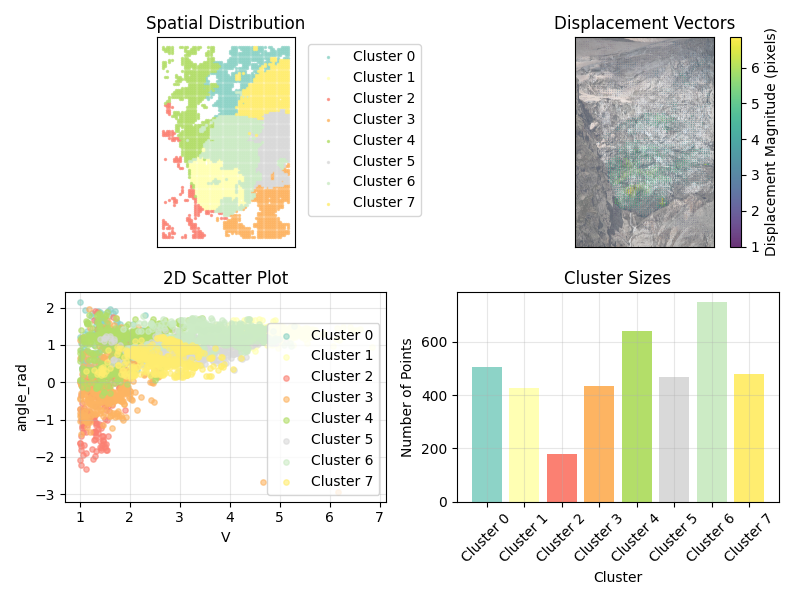

,Cluster,Count,Mean_Magnitude,Mean_Direction,Std_Magnitude
0,Cluster 0,506,1.723522,56.323935,0.366242
1,Cluster 1,427,4.662155,73.795739,0.667505
2,Cluster 2,180,1.364108,236.707002,0.213915
3,Cluster 3,433,1.618200,218.102232,0.443007
4,Cluster 4,640,1.987515,66.558966,0.616351
5,Cluster 5,469,3.144284,50.362663,0.649300
6,Cluster 6,748,3.658673,71.937241,0.625908
7,Cluster 7,479,2.654467,36.834928,0.504017


In [144]:
plot_clustering_results(
    df_features,
    labels,
    var_names=["V", "angle_rad"],
    img=img,
    figsize=(8, 6),
)

/home/francesco/cnr/ppcx/ppcx-domains/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


<Axes: title={'center': 'GMM Negative log-likelihood: V vs angle_rad'}, xlabel='V (scaled)', ylabel='angle_rad (scaled)'>

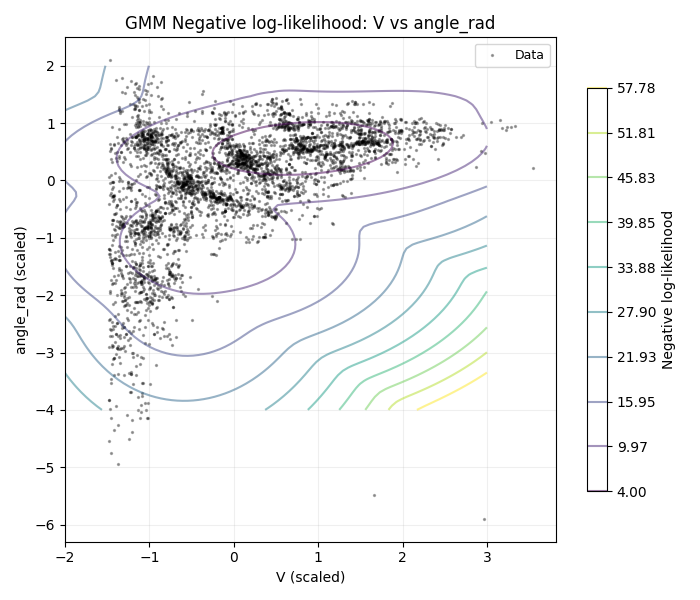

In [145]:
def plot_gmm_log_likelihood_contours(
    df,
    gmm,
    scaler,
    variables_names,
    pair=None,
    n_grid=80,
    ax=None,
    cmap="viridis",
    alpha=0.5,
):
    """
    Plot GMM negative log-likelihood contours for any pair of variables in n-dimensional space.
    - df: DataFrame with all features
    - gmm: fitted GaussianMixture
    - scaler: fitted StandardScaler
    - variables_names: list of all variable names used for GMM
    - pair: tuple/list of two variable names to plot (default: first two)
    - n_grid: grid resolution
    - ax: matplotlib axis (optional)
    - cmap: colormap for contours
    - alpha: contour transparency
    """
    import matplotlib.colors as mcolors

    if pair is None:
        pair = variables_names[:2]
    assert len(pair) == 2, "pair must be a tuple/list of two variable names"
    idx1, idx2 = [variables_names.index(v) for v in pair]

    # Prepare grid in the selected 2D space
    data_scaled = scaler.transform(df[variables_names])
    xlim = (
        np.floor(np.percentile(data_scaled[:, idx1], 1)),
        np.ceil(np.percentile(data_scaled[:, idx1], 99)),
    )
    ylim = (
        np.floor(np.percentile(data_scaled[:, idx2], 1)),
        np.ceil(np.percentile(data_scaled[:, idx2], 99)),
    )
    x = np.linspace(*xlim, n_grid)
    y = np.linspace(*ylim, n_grid)
    X, Y = np.meshgrid(x, y)
    grid = np.zeros((n_grid * n_grid, data_scaled.shape[1]))
    # Fill grid with mean values for all other variables
    grid[:] = np.mean(data_scaled, axis=0)
    grid[:, idx1] = X.ravel()
    grid[:, idx2] = Y.ravel()
    # Compute negative log-likelihood
    Z = -gmm.score_samples(grid)
    Z = Z.reshape(X.shape)

    # Plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 6))
    else:
        fig = ax.figure
    levels = np.linspace(np.percentile(Z, 5), np.percentile(Z, 99), 10)
    CS = ax.contour(
        X,
        Y,
        Z,
        levels=levels,
        cmap=cmap,
        alpha=alpha,
        linewidths=1.5,
        norm=mcolors.Normalize(vmin=levels[0], vmax=levels[-1]),
    )
    CB = fig.colorbar(CS, ax=ax, shrink=0.8, extend="both")
    CB.set_label("Negative log-likelihood")
    # Scatter the data points
    ax.scatter(
        data_scaled[:, idx1], data_scaled[:, idx2], s=2, c="k", alpha=0.3, label="Data"
    )
    ax.set_xlabel(f"{pair[0]} (scaled)")
    ax.set_ylabel(f"{pair[1]} (scaled)")
    ax.set_title(f"GMM Negative log-likelihood: {pair[0]} vs {pair[1]}")
    ax.axis("tight")
    ax.legend(loc="upper right", fontsize=9, frameon=True)
    ax.grid(True, alpha=0.2)
    plt.tight_layout()
    return ax


# Example usage:
plot_gmm_log_likelihood_contours(
    df_features, gmm, scaler, variables_names, pair=("V", "angle_rad")
)

Variational Bayesian Gaussian Mixture


In [146]:
df_features = preproc_features(df)

variables_names = ["x", "y", "V", "angle_rad"]
n_components = 6
max_iter = 100
random_state = 42
covariance_type = "full"

features = df_features[variables_names].values
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

gmm = GaussianMixture(
    n_components=n_components,
    covariance_type=covariance_type,
    max_iter=max_iter,
    random_state=random_state,
)
gmm.fit(features_scaled)
labels = gmm.predict(features_scaled)